# 写真からラーメンの種類を判別するモデルを作成

## 機能概要
写真データからラーメンの種類を判定
<br>
判別種類:<br>
- 醤油
- 味噌
- 豚骨
- 二郎系
- 家系

## インポート

In [1]:
# Standard
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import os

# PyTorch
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

## 定数

In [2]:
TRAIN_DATA_PATH = r"C:\\Users\\peper\\OneDrive\\TrainingData\\RamenAi"
DATA_SET_PATH = r"C:\\Users\\peper\\OneDrive\\TrainingData\\DataSet"

## モデル作成

In [3]:
# Init Setup

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 共通関数の読み込み

In [6]:
import sys
sys.path.append('..')

# 共通関数のロード
import importlib
import PyTorch_lib.lib1
importlib.invalidate_caches()
importlib.reload(PyTorch_lib.lib1)
from PyTorch_lib.lib1 import *

# 共通関数の存在チェック
print(README)

Common Library for PyTorch
Author: H. Hiroshi
Ver:1.0.1


## データ準備

In [7]:
import glob

data_dirs = glob.glob(TRAIN_DATA_PATH + "/*/")

## Transforms定義

In [8]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(1),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

## データセット定義

In [9]:
# ファイルを分ける
from sklearn.model_selection import train_test_split

train_files = np.zeros(1)
test_files = np.zeros(1)
for data_dir in data_dirs:
    train_add_files, test_add_files = train_test_split(glob.glob(data_dir + "/*"), train_size=0.7, test_size=0.3, random_state=123)
    train_files = np.append(train_files, train_add_files)
    test_files = np.append(test_files, test_add_files)

print(train_files.shape)
print(test_files.shape)
train_files = np.delete(train_files, 0, axis=0)
test_files = np.delete(test_files, 0, axis=0)
print(train_files.shape)
print(test_files.shape)

(622,)
(271,)
(621,)
(270,)


In [10]:
# 学習データ内のフォルダ検索
all_file_dir = os.listdir(TRAIN_DATA_PATH)

# 分類先クラスのリスト作成
classes = [f for f in all_file_dir if os.path.isdir(os.path.join(TRAIN_DATA_PATH, f))]

In [11]:
import shutil
from PIL import Image

if os.path.exists(DATA_SET_PATH):
    # DataSetフォルダを消す
    shutil.rmtree(DATA_SET_PATH)

# 分けたデータをtrain、testフォルダにコピー
os.makedirs(DATA_SET_PATH + "//train", exist_ok=True)
os.makedirs(DATA_SET_PATH + "//test", exist_ok=True)

# フォルダを作成
for dir_name in classes:
    os.makedirs(DATA_SET_PATH + "//train//" + dir_name, exist_ok=True)
    os.makedirs(DATA_SET_PATH + "//test//" + dir_name, exist_ok=True)

# ファイルをコピー
for copy_file in train_files:
    dst = copy_file.replace(TRAIN_DATA_PATH, DATA_SET_PATH + "//train")

    shutil.copy(copy_file, dst)
    if os.path.splitext(dst)[1] == '.jfif':
        im = Image.open(dst)
        im.convert("RGB").save(os.path.splitext(dst)[0] + ".jpg")
        os.remove(dst)
    # elif os.path.splitext(dst)[1] == '.avif':
    #     im = Image.open(dst)
    #     im.save(os.path.splitext(dst)[0] + ".jpg")
    #     os.remove(dst)

for copy_file in test_files:
    dst = copy_file.replace(TRAIN_DATA_PATH, DATA_SET_PATH + "//test")

    shutil.copy(copy_file, dst)
    if os.path.splitext(dst)[1] == '.jfif':
        im = Image.open(dst)
        im.convert("RGB").save(os.path.splitext(dst)[0] + ".jpg")
        os.remove(dst)
    # elif os.path.splitext(dst)[1] == '.avif':
    #     im = Image.open(dst)
    #     im.save(os.path.splitext(dst)[0] + ".jpg")
    #     os.remove(dst)


In [12]:
# 連番でコピーする
def auto_copy_file(src_file, dst_dir=None):
    """
    src_file: コピー元のファイルパス
    dst_folder: コピー先のフォルダパス
    """
    base_name = os.path.basename(src_file) # コピー元のファイル名を取得
    root, ext = os.path.splitext(base_name) # 拡張子を含まないファイル名と拡張子を取得
    if dst_dir == None:
        dst_dir = os.path.dirname(src_file) 
    
    dst_file = os.path.join(dst_dir, base_name)
    i = 1
    while os.path.exists(dst_file):
        # コピー先のファイル名が存在する場合は、連番を付けて別名をつける
        dst_file = os.path.join(dst_dir, root + '_' + str(i) + ext)
        i += 1
    shutil.copy2(src_file, dst_file)

In [13]:
# データセット定義
train_dir = DATA_SET_PATH + "//train"
test_dir = DATA_SET_PATH + "//test"

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform2)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=train_transform2)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [14]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 621件
検証データ: 270件


In [15]:
# データローダー定義

batch_size = 40

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=20, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=20, shuffle=True)

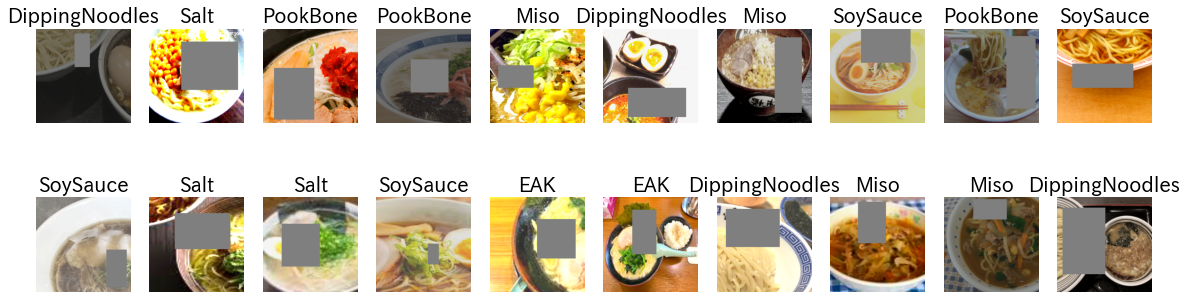

In [16]:
torch_seed()
show_images_labels(train_loader2, classes, None, None)

In [17]:
# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
# net = models.resnet152(pretrained = True)
net = models.efficientnet_b4(pretrained = True)

# すべてのパラメータで勾配計算なしに（転移学習）
# for param in net.parameters():
#     param.requires_grad = False
# for param in net.classifier.parameters():
#     param.requires_grad = True

# 乱数初期化
torch_seed()

# 最終ノードの出力を変更する
# ver vgg19
# in_features = net.classifier[6].in_features
# net.classifier[6] = nn.Linear(in_features, len(classes))
# ver resnet152
net.classifier = nn.Linear(net.classifier[1].in_features, len(classes))

# AdaptiveAvgPool2d関数の取り外し
# net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)
# optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

c:\Users\peper\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\peper\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
# 学習
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, scheduler, True, TRAIN_DATA_PATH)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.77016 acc: 0.38164 val_loss: 1.19796, val_acc: 0.66667


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.00063 acc: 0.65862 val_loss: 0.71736, val_acc: 0.72222


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.76678 acc: 0.73108 val_loss: 0.60597, val_acc: 0.79259


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59251 acc: 0.80354 val_loss: 0.53602, val_acc: 0.84074


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.44893 acc: 0.85507 val_loss: 0.52477, val_acc: 0.81481


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.45270 acc: 0.87118 val_loss: 0.41695, val_acc: 0.84815


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.36023 acc: 0.87118 val_loss: 0.49657, val_acc: 0.85556


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.36447 acc: 0.87279 val_loss: 0.56627, val_acc: 0.81852


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.33121 acc: 0.88728 val_loss: 0.52819, val_acc: 0.84444


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.31138 acc: 0.89211 val_loss: 0.56662, val_acc: 0.84074


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.29611 acc: 0.90499 val_loss: 0.48728, val_acc: 0.85926


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.31093 acc: 0.89211 val_loss: 0.50461, val_acc: 0.85556


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.27479 acc: 0.91948 val_loss: 0.39815, val_acc: 0.88148


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.33141 acc: 0.89533 val_loss: 0.42724, val_acc: 0.86667


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.23886 acc: 0.92432 val_loss: 0.46126, val_acc: 0.87037


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.24124 acc: 0.92432 val_loss: 0.36554, val_acc: 0.89630


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.18780 acc: 0.94847 val_loss: 0.40425, val_acc: 0.86667


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.25595 acc: 0.91465 val_loss: 0.48584, val_acc: 0.86296


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.23306 acc: 0.91948 val_loss: 0.43479, val_acc: 0.88148


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.23523 acc: 0.92754 val_loss: 0.55025, val_acc: 0.86667


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.19854 acc: 0.93076 val_loss: 0.49737, val_acc: 0.87037


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.17691 acc: 0.94364 val_loss: 0.53605, val_acc: 0.87037


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.15634 acc: 0.95008 val_loss: 0.62571, val_acc: 0.85185


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.19913 acc: 0.93720 val_loss: 0.53292, val_acc: 0.85556


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.25308 acc: 0.91626 val_loss: 0.43773, val_acc: 0.89630


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.15924 acc: 0.94525 val_loss: 0.45599, val_acc: 0.88148


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.19258 acc: 0.92915 val_loss: 0.50172, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.15688 acc: 0.95008 val_loss: 0.53030, val_acc: 0.87407


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.16572 acc: 0.94364 val_loss: 0.51295, val_acc: 0.89630


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.20394 acc: 0.94203 val_loss: 0.48125, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.16734 acc: 0.94686 val_loss: 0.55812, val_acc: 0.87037


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.15631 acc: 0.95491 val_loss: 0.50289, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.14075 acc: 0.95491 val_loss: 0.57544, val_acc: 0.86296


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.10066 acc: 0.96457 val_loss: 0.64982, val_acc: 0.86667


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.20622 acc: 0.93398 val_loss: 0.52654, val_acc: 0.90000


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.16602 acc: 0.95169 val_loss: 0.56421, val_acc: 0.85926


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.13240 acc: 0.95491 val_loss: 0.67477, val_acc: 0.86296


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.14672 acc: 0.95652 val_loss: 0.65370, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.19920 acc: 0.93881 val_loss: 0.60582, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.14661 acc: 0.95652 val_loss: 0.64171, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.15571 acc: 0.95169 val_loss: 0.49703, val_acc: 0.90370


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.16505 acc: 0.93881 val_loss: 0.52810, val_acc: 0.87778


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.12771 acc: 0.94525 val_loss: 0.53745, val_acc: 0.88148


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.11136 acc: 0.95974 val_loss: 0.55335, val_acc: 0.88519


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.11335 acc: 0.96135 val_loss: 0.59970, val_acc: 0.87037


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.13055 acc: 0.95491 val_loss: 0.76745, val_acc: 0.84444


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.15173 acc: 0.94203 val_loss: 0.68960, val_acc: 0.84444


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.16022 acc: 0.94847 val_loss: 0.72282, val_acc: 0.84815


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.14163 acc: 0.95330 val_loss: 0.64981, val_acc: 0.88148


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.13576 acc: 0.95330 val_loss: 0.61676, val_acc: 0.86667


初期状態: 損失: 1.19796 精度: 0.66667
最終状態: 損失: 0.61676 精度: 0.86667


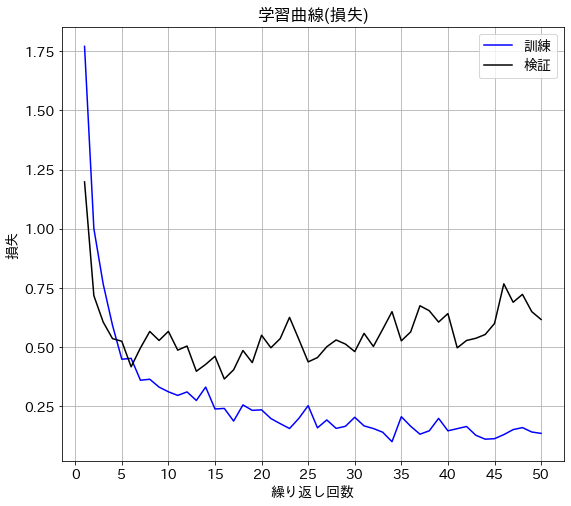

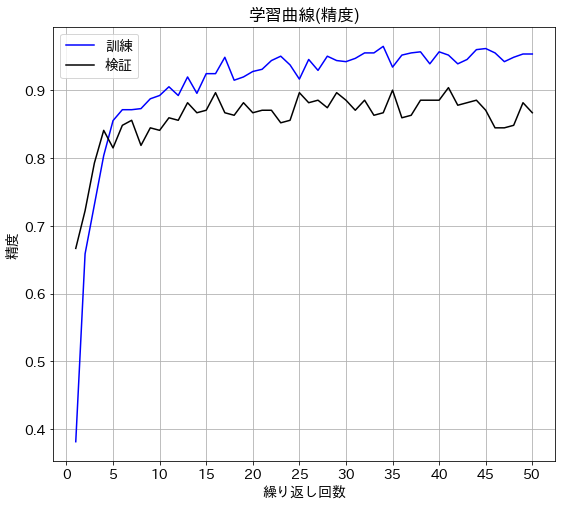

In [62]:
# 結果確認
evaluate_history(history)

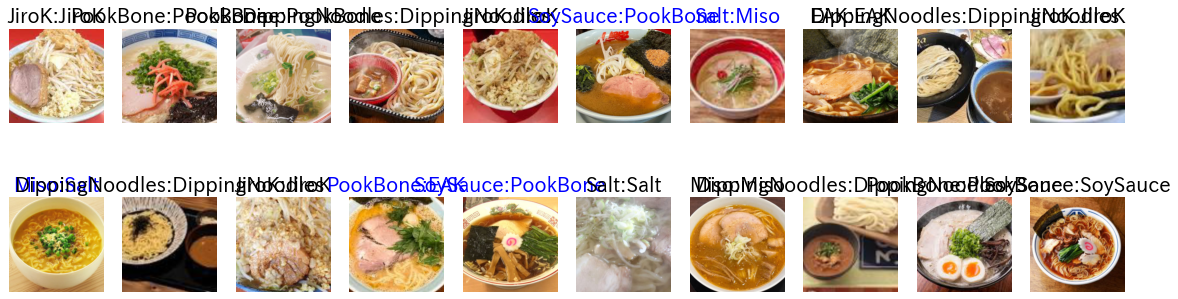

In [63]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)

## 後処理

In [64]:
# DataSetフォルダを消す
shutil.rmtree(DATA_SET_PATH)